In [197]:
from pandas import Series
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv


Загрузим данные

In [198]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')

In [199]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Заметим пропуски только в столбце образования(education). Избавимся от них.

In [200]:
train['education'].value_counts(normalize = True)

SCH    0.528765
GRD    0.317926
UGR    0.133566
PGR    0.017104
ACD    0.002640
Name: education, dtype: float64

In [201]:
train['education'].isnull().value_counts()

False    73492
True       307
Name: education, dtype: int64

Так как отсутствующих днных всвего 0,42% заполним пропуски самым популярным значением - SCH.

In [202]:
train['education'] = train['education'].fillna('SCH')
test['education'] = test['education'].fillna('SCH')

# Распределим данные на категории

In [203]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
# категориальные переменные
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki', 'region_rating', 'app_date']

## Бинарные данные

Присвоим каждому значению в этих даных числовой эквивалент.

In [204]:
label_encoder = LabelEncoder()
for i in bin_cols:
    train[i] = label_encoder.fit_transform(train[i])
    test[i] = label_encoder.fit_transform(test[i])

In [205]:
train[bin_cols].head()

,sex,car,car_type,foreign_passport,good_work
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,0,1,0
3,0,0,0,0,0
4,1,0,0,1,1


## Категориальные данные

Преобразуем строковые значения в столбце education в числовые эквиваленты.

In [206]:
train['education'] = label_encoder.fit_transform(train['education'])
test['education'] = label_encoder.fit_transform(test['education'])

In [207]:
X_cat_train = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)

Посмтрим значимость категориальных признаков для переменной default

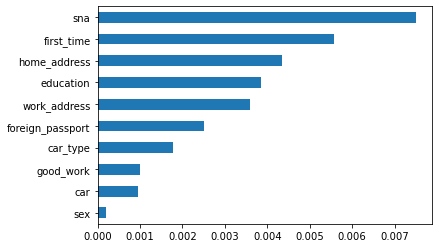

In [208]:
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                    discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Наиболее значимым признаком является sna(связь заемщика с клиентами банка)

## Числовые данные

Посмотрим графики обычных и логарифмированных величин

### 1. age

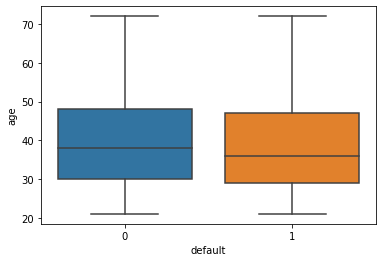

In [209]:
sns.boxplot(x="default", y="age", data=train)

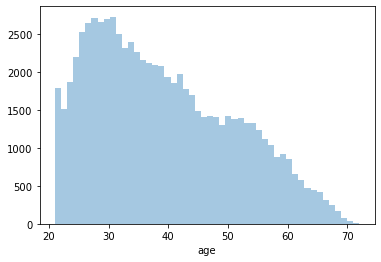

In [210]:
sns.distplot(train['age'], kde = False, rug=False)

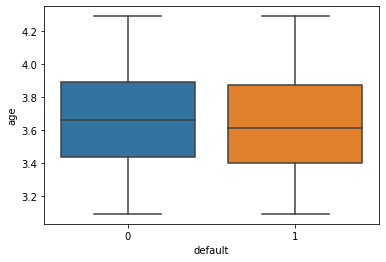

In [211]:
sns.boxplot(x="default", y=np.log1p(train['age']), data=train)

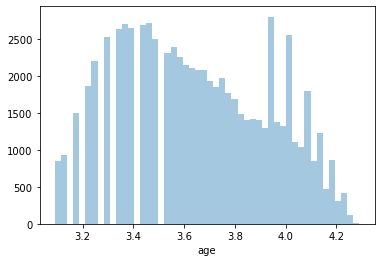

In [212]:
sns.distplot(np.log1p(train['age']), kde = False, rug=False)

### 2. decline_app_cnt

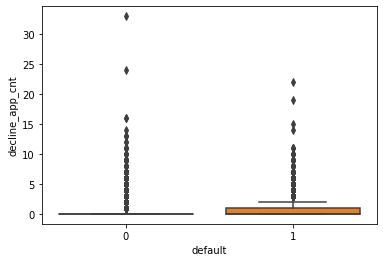

In [213]:
sns.boxplot(x="default", y="decline_app_cnt", data=train)

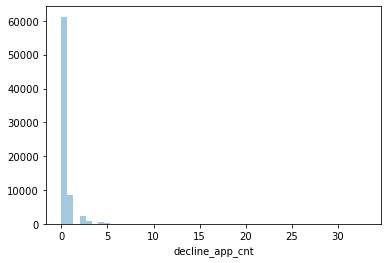

In [214]:
sns.distplot(train['decline_app_cnt'], kde = False, rug=False)

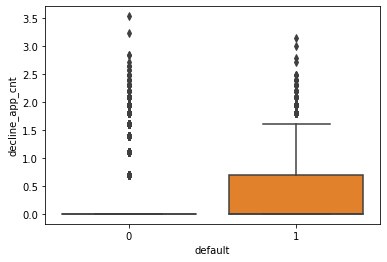

In [215]:
sns.boxplot(x="default", y=np.log1p(train["decline_app_cnt"]), data=train)

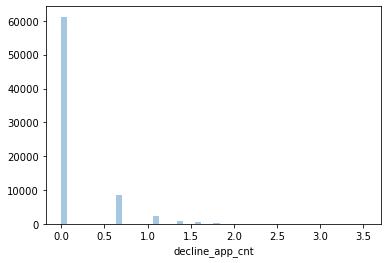

In [216]:
sns.distplot(np.log1p(train["decline_app_cnt"]), kde = False, rug=False)

Характер распределения не изменился, выбросы остались.

### 3. income

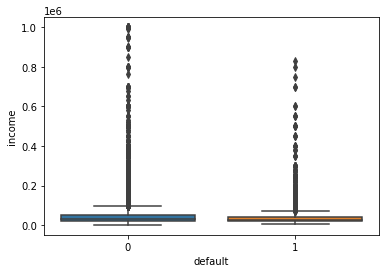

In [217]:
sns.boxplot(x="default", y="income", data=train)

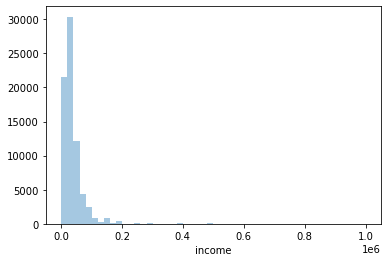

In [218]:
sns.distplot(train['income'], kde = False, rug=False)

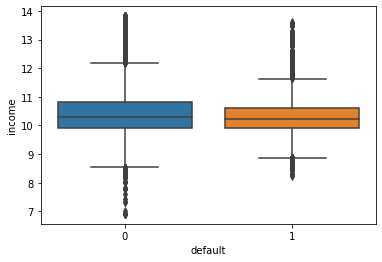

In [219]:
sns.boxplot(x="default", y=np.log1p(train["income"]), data=train)

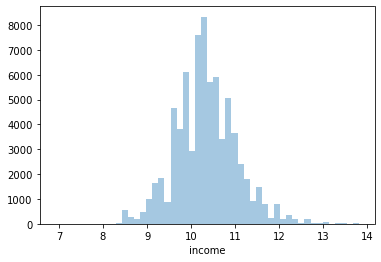

In [220]:
sns.distplot(np.log1p(train["income"]), kde = False, rug=False)

Выбросы остались, ярковыраженный логнармальное распредление

### 4. bki_request_cnt

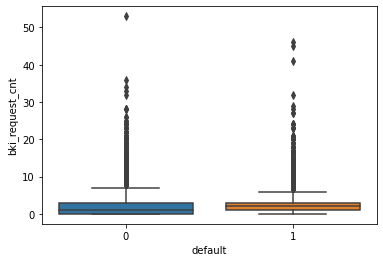

In [221]:
sns.boxplot(x="default", y="bki_request_cnt", data=train)

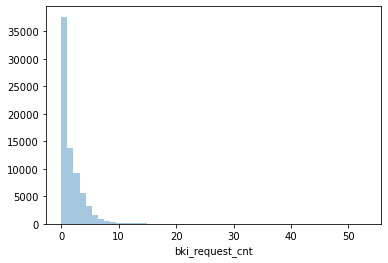

In [222]:
sns.distplot(train['bki_request_cnt'], kde = False, rug=False)

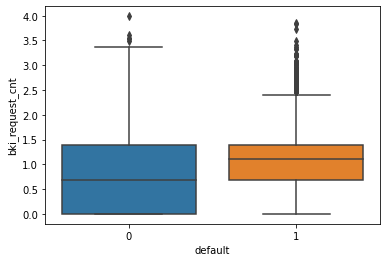

In [223]:
sns.boxplot(x="default", y=np.log1p(train["bki_request_cnt"]), data=train)

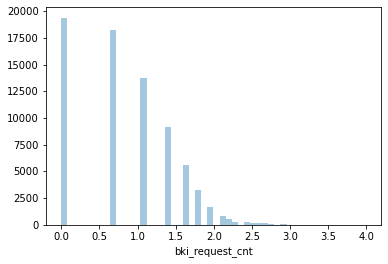

In [224]:
sns.distplot(np.log1p(train["bki_request_cnt"]), kde = False, rug=False)

### 5. score_bki

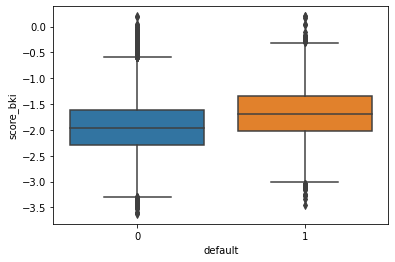

In [225]:
sns.boxplot(x="default", y="score_bki", data=train)

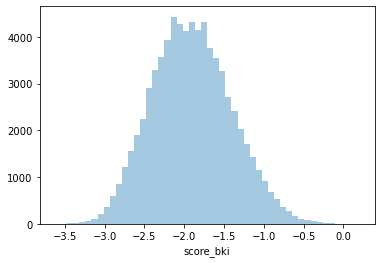

In [226]:
sns.distplot(train['score_bki'], kde = False, rug=False)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


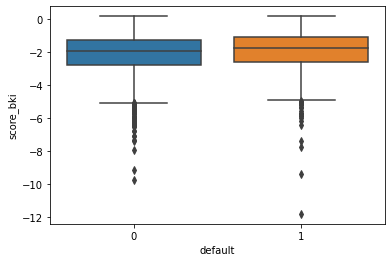

In [227]:
sns.boxplot(x="default", y=np.log1p(train["score_bki"]), data=train)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


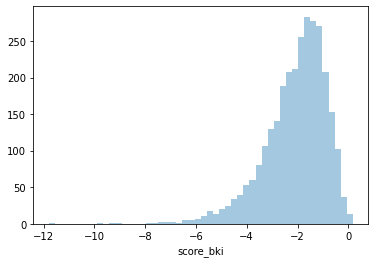

In [228]:
sns.distplot(np.log1p(train["score_bki"]), kde = False, rug=False)

Ярковыраженное нормальное распредление.

### 6. region_rating

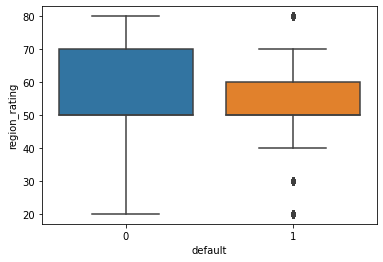

In [229]:
sns.boxplot(x="default", y="region_rating", data=train)

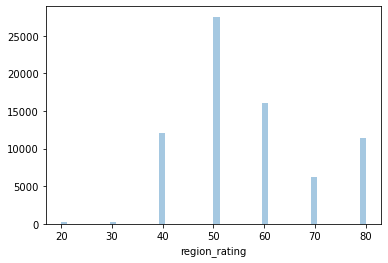

In [230]:
sns.distplot(train['region_rating'], kde = False, rug=False)

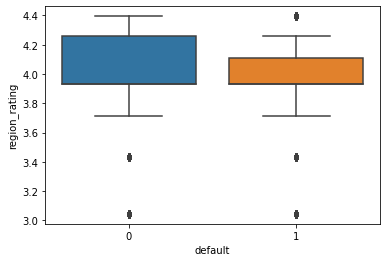

In [231]:
sns.boxplot(x="default", y=np.log1p(train["region_rating"]), data=train)

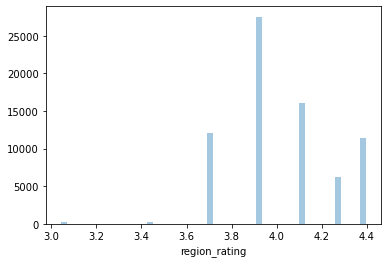

In [232]:
sns.distplot(np.log1p(train["region_rating"]), kde = False, rug=False)

### 7. app_date

На основе этого признака следует построить новый.

In [233]:
train["app_date"] = train["app_date"].apply(lambda x: datetime.strptime(x, '%d%b%Y'))
test["app_date"] = test["app_date"].apply(lambda x: datetime.strptime(x, '%d%b%Y'))

In [234]:
min_data_train = train['app_date'].min()
max_data_train = train['app_date'].max()
min_data_test = test['app_date'].min()
max_data_test = test['app_date'].max()

In [235]:
print(min_data_train)
print(max_data_train)

2014-01-01 00:00:00
2014-04-30 00:00:00


Период довольно короткий для оценки каких либо периодов. Поэтому просто выразим количество дней, от начала наблюдений, до даты заявки.

In [236]:
train['days'] = train['app_date'] - min_data_train
test['days'] = test['app_date'] - min_data_test

In [237]:
train['days'] = train['days'].apply(lambda x: int(x.days))
test['days'] = test['days'].apply(lambda x: int(x.days))

In [238]:
num_cols.append('days')
num_cols.remove('app_date')

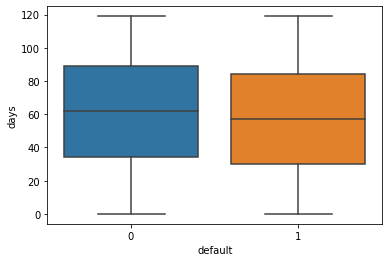

In [239]:
sns.boxplot(x="default", y="days", data=train)

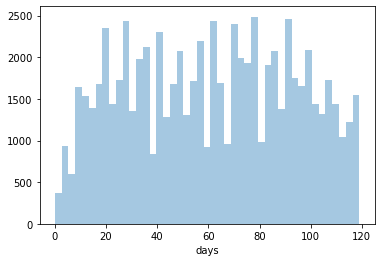

In [240]:
sns.distplot(train['days'], kde = False, rug=False)

**В результате прологарифмируем два столбца: age и income**

In [241]:
train['age'] = np.log1p(train['age'])
train['income'] = np.log1p(train['income'])
test['age'] = np.log1p(test['age'])
test['income'] = np.log1p(test['income'])

Оценим карреляцию

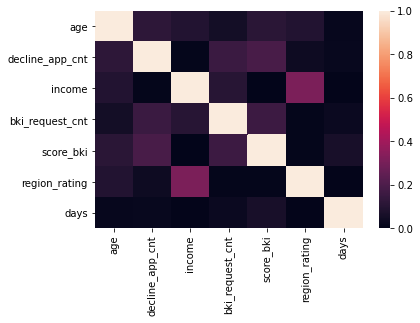

In [242]:
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1)

Сильной корреляции не наблюдается. Оставляем данные.

Стандартизируем наши данные

In [243]:
X_num_train = StandardScaler().fit_transform(train[num_cols].values)
X_num_test = StandardScaler().fit_transform(test[num_cols].values)

In [244]:
X = np.hstack([X_num_train, train[bin_cols].values, X_cat_train])
Y = train['default'].values

Разделим выборку на тренировочную и вылидационнную.

In [245]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20, random_state=42)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


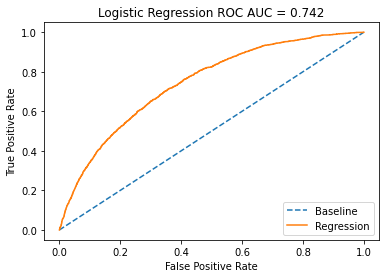

In [246]:
model = LogisticRegression()
model.fit(X_train, Y_train)

probs = model.predict_proba(X_val)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(Y_val, probs)
roc_auc = roc_auc_score(Y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [247]:
y_pred = model.predict(X_val)
print(f1_score(Y_val, y_pred))

0.03732503888024884


Поиск лучших гиперпараметров

In [248]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

#solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
class_weight = ['balanced', None]

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty,class_weight=class_weight)

model = LogisticRegression()
model.fit(X_train, Y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, Y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
#print('Лучшее solver:', best_model.best_estimator_.get_params()['solver'])
print('Лучшее class_weight:', best_model.best_estimator_.get_params()['class_weight'])


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/line

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/line

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for

Лучшее Penalty: l2
Лучшее C: 1.0
Лучшее class_weight: None


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Переобучим модель

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


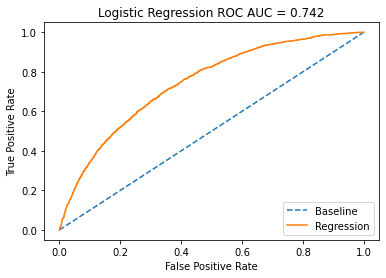

In [249]:
model = LogisticRegression(penalty = 'l2', C=1, class_weight='None', solver ='saga')
model.fit(X_train, Y_train)
probs = model.predict_proba(X_val)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(Y_val, probs)
roc_auc = roc_auc_score(Y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

ROC AUC = 0.742

Проверим результат на тестовой выборке

In [251]:
X_test = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])
client_id = test['client_id']

In [252]:
model = LogisticRegression(penalty = 'l2', C=166, class_weight='None',solver ='saga')
model.fit(X, Y)
probs = model.predict_proba(X_test)
probs = probs[:,1]

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [253]:
my_submission = pd.DataFrame({'client_id': client_id, 
                            'default': probs})
my_submission.to_csv('submission.csv', index=False)

my_submission

,client_id,default
0,74835,0.036044
1,17527,0.347750
2,75683,0.060689
3,26883,0.093765
4,28862,0.030786
...,...,...
36344,83775,0.289550
36345,106254,0.015846
36346,81852,0.304834
36347,1971,0.187367
